In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.autograd as autograd

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm.autonotebook import tqdm
from skimage.color import rgb2lab, lab2rgb

from sklearn.model_selection import train_test_split

#pip install -q torchsummary
from torchsummary import summary

In [169]:
# download issues
# import os
# os.chdir(r'../working')
# from IPython.display import FileLink
# FileLink(r'model.pth')

In [2]:
seed = 42
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

BATCH_SIZE = 16  # initially 4, then 8
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
epochs = 100
loss_lambda = 100
gp_lambda = 10 # for alt. version
ep = 0

PATH = 'model.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [ ]:
path = r'../input/image-colorization-dataset/data/'

grays = glob(path + 'train_black' + '/*.jpg')
colored = glob(path + 'train_color' + '/*.jpg')

grays = sorted([str(x) for x in grays])
colored = sorted([str(x) for x in colored])

df_train = pd.DataFrame(data={'gray': grays, 'color': colored})

In [ ]:
grays = glob(path + 'test_black' + '/*.jpg')
colored = glob(path + 'test_color' + '/*.jpg')

grays = sorted([str(x) for x in grays])
colored = sorted([str(x) for x in colored])

test = pd.DataFrame(data={'gray': grays, 'color': colored})

In [3]:
# alternative dataset (COCO2014 - test)
coco = glob(r'test2014' + '/*.jpg')
coco = sorted([str(x) for x in coco])

df = pd.DataFrame(data={'color': coco, 'name': np.zeros(len(coco))}).sample(17200)
train, valid = train_test_split(df, test_size=0.2, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, valid size: {len(valid)}')
# end alternative

Train size: 13760, valid size: 3440


In [ ]:
# optionaly
df_train = pd.concat([df_train, test], axis=0)
print(f'Total size: {df_train.shape}')

In [ ]:
train, valid = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=seed)
print(f'Train size: {len(train)}, valid size: {len(valid)}') #, test size: {len(test)}.')

```
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.5),
                      A.ToGray(p=0.01),
                      A.HorizontalFlip(p=0.1),
                      A.VerticalFlip(p=0.1),
                      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1),
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.2),
                      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
                      ToTensorV2(p=1.0),
                      ],p=1.0,)
# bbox?
# set params while applying transforms
```

In [4]:
train_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
                              T.RandomHorizontalFlip(p=0.2),
])
final_transforms = T.Compose([
                        T.ToTensor(),
])
valid_transforms = T.Compose([
                              T.ToPILImage(),
                              T.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
])

In [5]:
class ColorDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ix):
        row = self.df.iloc[ix].squeeze()
        color_image = cv2.imread(row['color'])
        color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)
        color_image = self.transforms(color_image)
        color_image = np.array(color_image)
        img_lab = rgb2lab(color_image).astype("float32")
        img_lab = final_transforms(img_lab)
        L = img_lab[[0], ...] / 50. - 1.
        ab = img_lab[[1, 2], ...] / 110.
        return L, ab
    
    def collate_fn(self, batch):
        L, ab = list(zip(*batch))
        L = [l[None].to(device) for l in L]
        ab = [a_b[None].to(device) for a_b in ab]
        L, ab = [torch.cat(i) for i in [L, ab]]
        return L, ab

In [6]:
train_dataset = ColorDataset(train, train_transforms)
valid_dataset = ColorDataset(valid, valid_transforms)
# test_dataset = ColorDataset(test, valid_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_dataset.collate_fn, drop_last=True)

In [27]:
# initially batchnorm2d; Dropout may add unnecessary noise.
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False, instance=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni) if not instance else nn.InstanceNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf) if not instance else nn.InstanceNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64, instance=False):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True, instance=instance)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=False, instance=instance)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block, instance=instance)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True, instance=instance)
    
    def forward(self, x):
        return self.model(x)

In [23]:
# initially no dropout and batchnorm2d (batchnorm and leakyrelu, gelu prevent from vanishing grads)
# instance norm computes learnable parameters for every instance in batch, it is better when instances have diff. distributions
# dropout should be disabled for generator while training the discriminator or at any testing stage
# using batchnorm assuming images have same color distribution
# Conv > Normalization > Activation > Dropout > Pooling

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # spectral or instance norms? Dropout?
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # InstanceNorm after first conv layer does not preserve the color of image
            
            nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False), n_power_iterations=2),
            #nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            # nn.InstanceNorm2d(128), 
            nn.BatchNorm2d(128),  
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False), n_power_iterations=2),
            #nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            # nn.InstanceNorm2d(256), 
            nn.BatchNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False), n_power_iterations=2),
            #nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            # nn.InstanceNorm2d(512), 
            nn.BatchNorm2d(512), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid() # uncomment if using binary_cross_entropy loss or use binary_cross_entropy_with_logits (preferable)
        )

    def forward(self, input):
        return self.discriminator(input)

In [10]:
criterion_content_loss = nn.L1Loss()  # nn.MSELoss?

def gan_loss(model_type, **kwargs):
    if model_type == 'G':
        recon_discriminator_out = kwargs['recon_discriminator_out']
        return nn.functional.binary_cross_entropy(recon_discriminator_out, torch.ones_like(recon_discriminator_out))

    elif model_type == 'D':
        color_discriminator_out = kwargs['color_discriminator_out']
        recon_discriminator_out = kwargs['recon_discriminator_out']
        real_loss = nn.functional.binary_cross_entropy(color_discriminator_out, torch.ones_like(color_discriminator_out))
        fake_loss = nn.functional.binary_cross_entropy(recon_discriminator_out, torch.zeros_like(recon_discriminator_out))
        return (real_loss + fake_loss) / 2.0
    
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1, 0.02)
        nn.init.zeros_(m.bias)

In [28]:
# if using generator from scratch - uncomment
generator = Unet(input_c=1, output_c=2, n_down=8, num_filters=64, instance=False).apply(init_weights).to(device)
discriminator = Discriminator().apply(init_weights).to(device)

In [29]:
# initially lr_G = 1e-4, lr_D = 2e-4, lr_decay_G = lr_decay_D = 1e-6
# the bigger batch_size the bigger learning rate
optimizerG = torch.optim.AdamW(generator.parameters(), lr=2e-4, betas=(0.5, 0.999), amsgrad=True) #, weight_decay=1e-4) #
optimizerD = torch.optim.AdamW(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999), amsgrad=True) #, weight_decay=1e-4) #

# Optionally include schedulers # Adam applies lr_decay internally but we can manage upper lr bound
#schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=20, gamma=0.5)
#schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=20, gamma=0.5)
#schedulerD = torch.optim.lr_scheduler.LambdaLR(optimizerD, lr_lambda=lambda epoch: 1 if epoch <= 40 else 0.5, verbose=True)

In [30]:
summary(generator, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,024
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

In [31]:
summary(discriminator, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
           Dropout-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,288
       BatchNorm2d-8          [-1, 256, 32, 32]             512
         LeakyReLU-9          [-1, 256, 32, 32]               0
          Dropout-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
        LeakyReLU-13          [-1, 512, 16, 16]               0
          Dropout-14          [-1, 512,

In [32]:
def grad_req(model, is_required=True):
    for param in model.parameters():
        param.requires_grad = True

def PSNR(fake_image, real_image):
    mse = torch.mean((fake_image - real_image) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 110  # max pix for skimage L{AB} 
    return 10 * np.log10(PIXEL_MAX ** 2 / mse)

# for future investigation: SSIM quality measurement?

In [12]:
def train_one_batch(generator, discriminator, data, criterion_content_loss, optimizerG, optimizerD):
    generator.train()
    discriminator.train()

    L, ab = data

    fake_color = generator(L)
    grad_req(discriminator, True)
    
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image.detach())
    
    optimizerD.zero_grad()

    real_image = torch.cat([L, ab], dim=1)
    real_preds = discriminator(real_image)
    kwargs = {
              'color_discriminator_out': real_preds, 
              'recon_discriminator_out': fake_preds,  
             }
    d_loss = gan_loss('D', **kwargs)
    d_loss.backward()
    optimizerD.step()

    grad_req(discriminator, False)
    optimizerG.zero_grad()
    
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image)
    
    kwargs = {
              'recon_discriminator_out': fake_preds, 
              }    
    g_loss_gan = gan_loss('G', **kwargs)
    loss_G_L1 = criterion_content_loss(fake_color, ab) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    g_loss.backward()
    optimizerG.step()

    torch.nn.utils.clip_grad_norm_(generator.parameters(), 10.0)
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 10.0)
    
    with torch.no_grad():
        denorm_fake_color = fake_color.detach().cpu() * 110
        denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss.item(), g_loss.item(), metric

@torch.no_grad()
def validate(generator, discriminator, data, criterion_content_loss):
    generator.eval()
    discriminator.eval()

    L, ab = data
    
    fake_color = generator(L)
    fake_image = torch.cat([L, fake_color], dim=1)
    real_image = torch.cat([L, ab], dim=1)
    
    color_discriminator_out = discriminator(real_image)
    recon_discriminator_out = discriminator(fake_image)
    kwargs = {
              'color_discriminator_out': color_discriminator_out, 
              'recon_discriminator_out': recon_discriminator_out,  
             }
    d_loss = gan_loss('D', **kwargs)
    
    kwargs = {
              'recon_discriminator_out': recon_discriminator_out, 
              }    
    g_loss_gan = gan_loss('G', **kwargs) 
    loss_G_L1 = criterion_content_loss(fake_color, ab) * loss_lambda 
    g_loss = g_loss_gan + loss_G_L1
    
    denorm_fake_color = fake_color.detach().cpu() * 110
    denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss.item(), g_loss.item(), metric

@torch.no_grad()
def visual_validate(data, generator):
    L, ab = data
    generator.eval()
    out = generator(L)
    i = np.random.randint(0, BATCH_SIZE)
    out, L, ab = out[i], L[i], ab[i]
    L = (L + 1) * 50
    ab = ab * 110
    out = out * 110
    true_image = lab2rgb(torch.cat([L, ab]).detach().cpu().numpy(), channel_axis=0).transpose(1,2,0)
    black_image = L.detach().cpu().numpy().squeeze()
    out_image = lab2rgb(torch.cat([L, out]).detach().cpu().numpy(), channel_axis=0).transpose(1,2,0)
    plt.figure(figsize=(12,14))
    plt.subplot(131)
    plt.title('Black')
    plt.imshow(black_image, cmap='gray')
    plt.subplot(132)
    plt.title('Colored')
    plt.imshow(true_image)
    plt.subplot(133)
    plt.title('Black Colored')
    plt.imshow(out_image)
    plt.show()
    plt.pause(0.001)

#### Alternative: WGAN Loss

In [33]:
CONV3_3_IN_VGG_19 = torchvision.models.vgg19(pretrained=True, progress=False).features[:15].to(device)

def PSNR(fake_image, real_image):
    mse = torch.mean((fake_image - real_image) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 110
    return 10 * np.log10(PIXEL_MAX ** 2 / mse)

class WGANLoss(nn.Module):
    def forward(self, mtype, **kwargs):
        if mtype == 'G':
            fake_preds = kwargs['fake_preds']
            return -fake_preds.mean()

        elif mtype == 'D':  
            gp_lambda = kwargs['gp_lambda']
            interpolates = kwargs['interpolates']
            interpolates_discriminator_out = kwargs['interpolates_discriminator_out']
            real_discriminator_out = kwargs['real_discriminator_out']
            fake_discriminator_out = kwargs['fake_discriminator_out']

            wgan_loss = fake_discriminator_out.mean() - real_discriminator_out.mean()

            gradients = autograd.grad(outputs=interpolates_discriminator_out, inputs=interpolates,
                                      grad_outputs=torch.ones(interpolates_discriminator_out.size()).to(device),
                                      retain_graph=True,
                                      create_graph=True)[0]
            gradient_penalty = ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()

            return wgan_loss, gp_lambda * gradient_penalty

class ContentLoss(nn.Module):
    def forward(self, fake_image, real_image, model=CONV3_3_IN_VGG_19):
        fake_feature_map = model.forward(fake_image)
        real_feature_map = model.forward(real_image).detach()
        loss = nn.functional.mse_loss(fake_feature_map, real_feature_map)
        return loss
    
criterion_wgan = WGANLoss()
criterion_content = ContentLoss()

In [34]:
def train_one_batch(generator, discriminator, data, criterion_content, optimizerG, optimizerD, critic_updates=5):
    generator.train()
    discriminator.train()

    L, ab = data

    grad_req(discriminator, True)
    
    d_loss = 0
    for _ in range(critic_updates):
        fake_color = generator(L)
        fake_image = torch.cat([L, fake_color], dim=1)
        real_image = torch.cat([L, ab], dim=1)

        fake_preds = discriminator(fake_image.detach())
        real_preds = discriminator(real_image) # detach()
        
        optimizerD.zero_grad()

        alpha = np.random.random()
        interpolates = alpha * real_image + (1 - alpha) * fake_image
        #interpolates = (alpha * real_image.detach() + (1 - alpha) * fake_image.detach()).requires_grad_(True)
        interpolates_discriminator_out = discriminator(interpolates)
        
        kwargs = {
                  'gp_lambda': gp_lambda,
                  'interpolates': interpolates, 
                  'interpolates_discriminator_out': interpolates_discriminator_out, 
                  'real_discriminator_out': real_preds, 
                  'fake_discriminator_out': fake_preds,  
                  }
        wgan_loss_d, gp_d = criterion_wgan('D', **kwargs)
        discriminator_loss_per_update = wgan_loss_d + gp_d
        discriminator_loss_per_update.backward(retain_graph=True)
        optimizerD.step()
        d_loss += discriminator_loss_per_update.item()
    d_loss /= critic_updates

    grad_req(discriminator, False)
    optimizerG.zero_grad()

    fake_color = generator(L) ## or commetn to use from the last critic update 
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image)
    
    kwargs = {
              'fake_preds': fake_preds, 
              }    
    g_loss_gan = criterion_wgan('G', **kwargs)
    loss_G_L1 = criterion_content(fake_image, real_image) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    g_loss.backward()
    optimizerG.step()

    # if not using gradient penalty, add torch.clamp(discriminator.params, -0.01, 0.01) or normalized clamp as above
    #torch.nn.utils.clip_grad_norm_(generator.parameters(), 10.0)
    #torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 10.0)
    
    with torch.no_grad():
        denorm_fake_color = fake_color.detach().cpu() * 110
        denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss, g_loss.item(), metric

@torch.no_grad()
def validate(generator, discriminator, data, criterion_content):
    generator.eval()
    discriminator.eval()

    L, ab = data
    
    fake_color = generator(L)
    fake_image = torch.cat([L, fake_color], dim=1)
    real_image = torch.cat([L, ab], dim=1)
    
    color_discriminator_out = discriminator(real_image)
    recon_discriminator_out = discriminator(fake_image)

    d_loss = recon_discriminator_out.mean() - color_discriminator_out.mean()
    
    kwargs = {
              'fake_preds': recon_discriminator_out, 
              }    
    g_loss_gan = criterion_wgan('G', **kwargs)
    loss_G_L1 = criterion_content(fake_image, real_image) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    
    denorm_fake_color = fake_color.detach().cpu() * 110
    denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return d_loss.item(), g_loss.item(), metric

#### end alternatve part

In [35]:
@torch.no_grad()
def test_show(model):
    model.eval()
    ix = np.random.randint(len(valid))
    L, ab = valid_dataset[ix]
    L, ab = torch.Tensor(L).unsqueeze(0).to(device), torch.Tensor(ab).unsqueeze(0).to(device)
    out = model(L) # generator
    L = (L + 1) * 50
    ab = ab * 110
    out = out * 110
    true_image = lab2rgb(torch.cat([L, ab], dim=1).squeeze().detach().cpu().numpy(), channel_axis=0).transpose(1,2,0)
    black_image = L.detach().cpu().numpy().squeeze()
    out_image = lab2rgb(torch.cat([L, out], dim=1).squeeze().detach().cpu().numpy(), channel_axis=0).transpose(1,2,0)
    plt.figure(figsize=(12,14))
    plt.subplot(131)
    plt.title('Black')
    plt.imshow(black_image, cmap='gray')
    plt.subplot(132)
    plt.title('Colored')
    plt.imshow(true_image)
    plt.subplot(133)
    plt.title('Black Colored')
    plt.imshow(out_image)
    plt.show()
    plt.pause(0.001)

In [16]:
try:
    checkpoint = torch.load('model_54epochs_spect.pth')  # PATH
    ep, generator, discriminator, optimizerG, optimizerD = tuple(checkpoint.values())
except:
    ep = 0
ep += 1
# 3) (2) + lrD = 1e-4, double discriminator train
# 2) Dropout OFF, batch=16 with lrx2 = 2e-4, no scheduler and no weight-decay
# 1) Dropout ON, batch=4, D=2e-4, G=1e-4, weight_decay, scheduler lambda.

In [ ]:
# attempt to add spectral norm to already trained discriminator. SKIP if working from scratch
for name, child in discriminator.named_children():
    for i, ch in enumerate(child[1:-2]):
        if isinstance(ch, nn.Conv2d):
            print(ch)
            ch = nn.utils.spectral_norm(ch, n_power_iterations=2)

In [ ]:
train_d_losses, train_g_losses, valid_d_losses, valid_g_losses = [], [], [], []

for epoch in range(ep, epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    #upd = 1 if epoch % 3 == 0 else 2
    upd = 2
    
    train_epoch_d_loss, train_epoch_g_loss = [],[]
    for _, data in enumerate(tqdm(train_dataloader, leave=False)):
        with torch.autograd.set_detect_anomaly(True):
            d_loss, g_loss, metric = train_one_batch(generator, discriminator, data, criterion_content_loss, 
                                                     optimizerG, optimizerD, critic_updates=upd) # modified function
        train_epoch_d_loss.append(d_loss)
        train_epoch_g_loss.append(g_loss)
    epoch_d_loss = np.array(train_epoch_d_loss).mean()
    epoch_g_loss = np.array(train_epoch_g_loss).mean()
    train_d_losses.append(epoch_d_loss)
    train_g_losses.append(epoch_g_loss)
    print(f'Train D loss: {epoch_d_loss:.4f}, train G loss: {epoch_g_loss:.4f}, PSNR: {metric:.4f}')

    valid_epoch_g_loss, valid_epoch_d_loss = [],[]
    for _, data in enumerate(tqdm(valid_dataloader, leave=False)):
        d_loss, g_loss, metric = validate(generator, discriminator, data, criterion_content_loss)
        valid_epoch_g_loss.append(g_loss)
        valid_epoch_d_loss.append(d_loss)
    epoch_g_loss = np.array(valid_epoch_g_loss).mean()
    epoch_d_loss = np.array(valid_epoch_d_loss).mean()
    valid_g_losses.append(epoch_g_loss)
    valid_d_losses.append(epoch_d_loss)
    print(f'Validation D loss: {epoch_d_loss:.4f}, validation G loss: {epoch_g_loss:.4f}, PSNR: {metric:.4f}')
    print('-'*50)    
    
    # Optionally include schedulers
    schedulerD.step()
    # schedulerG.step()
    if (epoch + 1) % 2 == 0:
        checkpoint = {
                      'epoch': epoch,     
                      'G': generator,
                      'D': discriminator,
                      'optimizerG': optimizerG,
                      'optimizerD': optimizerD,
                      }
        torch.save(checkpoint, 'W_'+PATH) # WGAN
        # data = next(iter(valid_dataloader))
        # visual_validate(data, generator)
        test_show(generator)

Epoch 1/100


 86%|████████████████████████████████████████████████████████████████████▍           | 736/860 [16:54<02:50,  1.38s/it]

**To the 38 epoch (with BCE and L1 loss) we have: discriminator loss increasing over epochs, while generator loss decreases. One possible reason is: the discriminator starts detecting fake (generated) images as real. Thus, generator loss (first part: D(fake, 1)) begins to decrease a bit, while discriminator fake loss increases (D(fake, 0)). This is not good as generator then begins to generate the same bad quality images as even such similar outputs can fool discriminator.**
* decrease learning rate(s) and (or) modify train function to train discriminator twice (or more) before generator?
* as experiment: change number of discriminator updates every 3 epoch to 1 or zero (if using modified function)
* next apply spectral normalization to Conv2ds (BatchNorms apply to feature maps, Spectral - to layer's parameters - weights).

**If making it from scratch**
* make more complex discriminator model and retrain, maybe with InstanceNorm (make Gaussian distr. on every 'image')?
* do not pretrain generator and use basic unet without dropout (that adds more noise than stability)?
* apply gradient penalty (and multiple updates if necessary) in discriminator or (and) spectral norm?
* uncomment dropout layers in discriminator architecture and set p=0.5 (randomly switch off 50% of neurons)

#### For the next try:
* UNET model for generator from scratch without dropout
* batch = 16, lrx2 = 2e-4, AdamW
* spectral norm, batchNorm and dropout0.5 in Discriminator
* WGAN loss with gradient penalty, 2 critic updates in discriminator

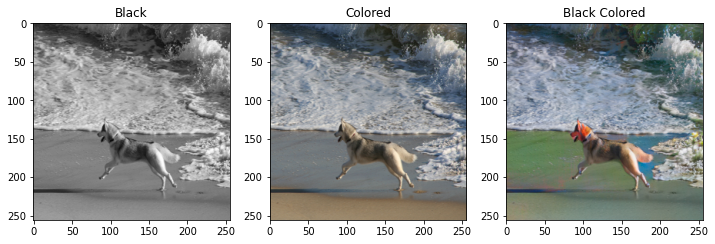

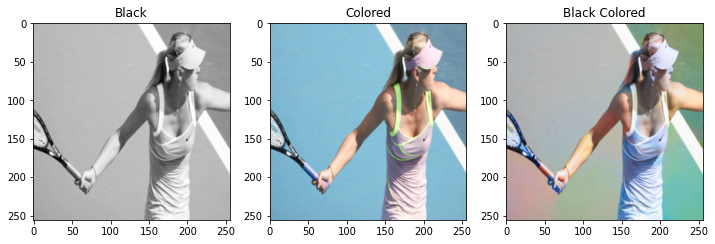

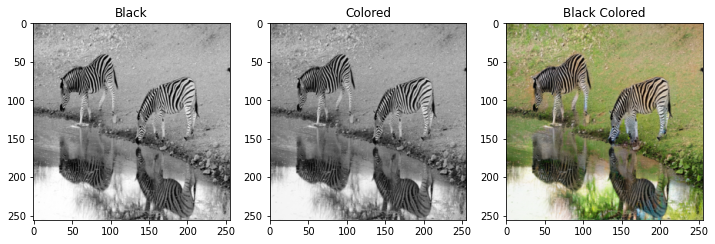

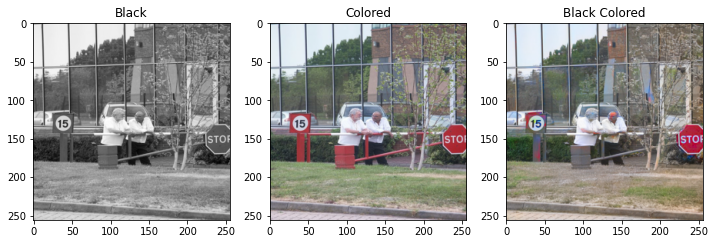

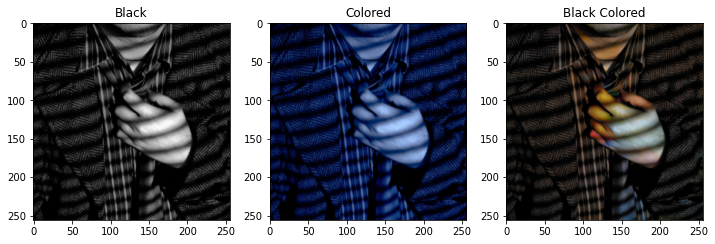

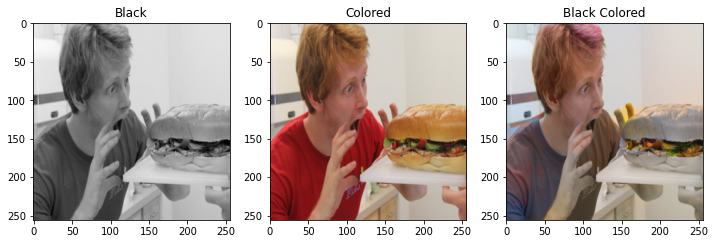

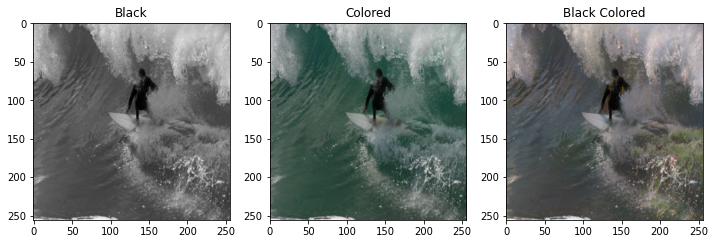

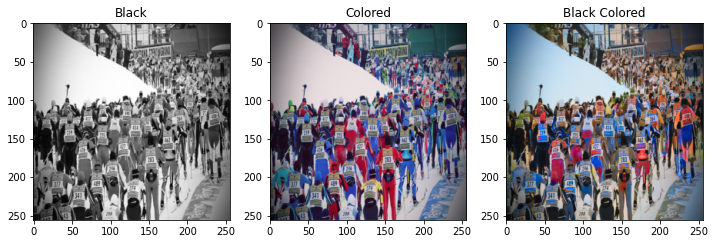

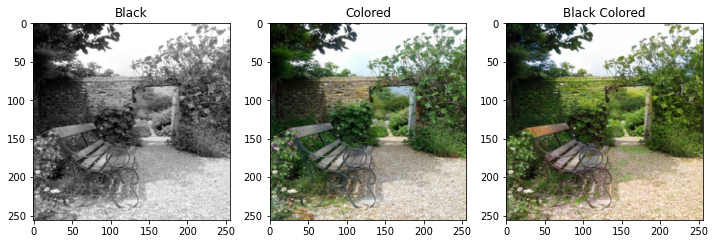

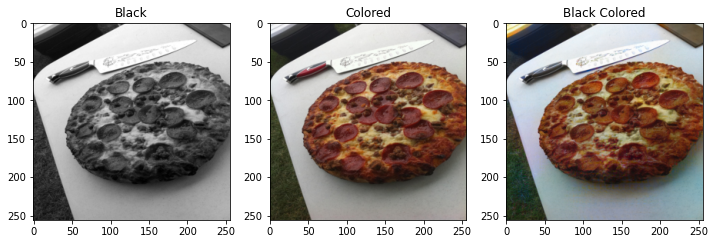

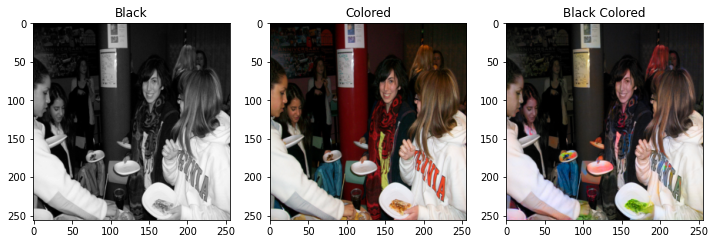

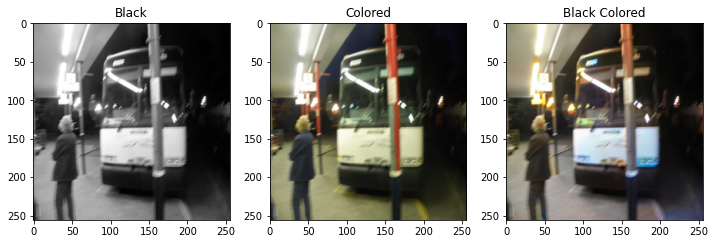

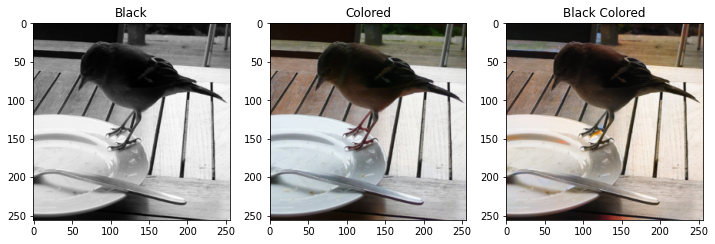

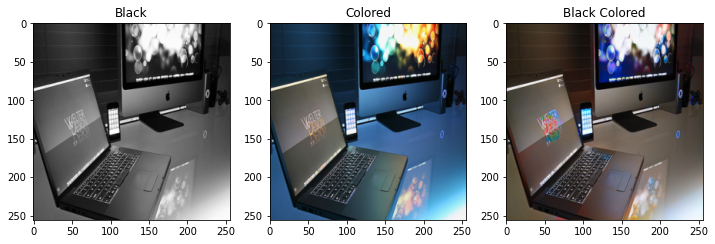

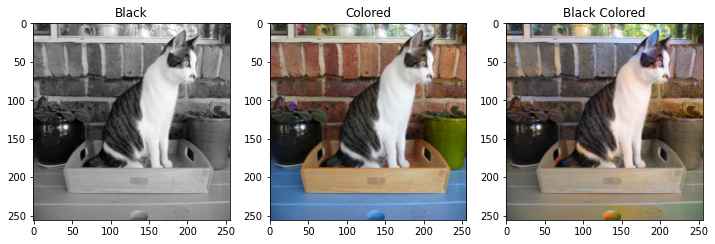

In [20]:
for _ in range(15):
    test_show(generator)

#### As the author suggests we may use pretrained Unet model to retrain it on colorization task and only then use it in our above Unet-GAN implementation (just pass it to the train_one_batch, validate functions), which significantly improves the quality of colorization results

[https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8](http://)

#### For discriminator we also may use pretrained model, e.i. from torch.models., such as vgg16, resnet18, efficient_b0, etc.

In [14]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in tqdm(range(epochs), total=epochs, leave=False):
        for data in tqdm(train_dl, total=len(train_dl), leave=False):
            L, ab = data
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

generator = build_res_unet(n_input=1, n_output=2, size=256)

# Alredy trained
#opt = torch.optim.Adam(generator.parameters(), lr=1e-4)
#criterion = nn.L1Loss()        
#pretrain_generator(generator, train_dataloader, opt, criterion, 20)
#torch.save(generator.state_dict(), 'generator.pth')

In [15]:
generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

In [ ]:
!pip install -qq efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

def get_d_model(sigmoid=True):
    model = EfficientNet.from_name('efficientnet-b0')
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model._fc.in_features
    layers = [nn.Linear(num_ftrs, 1), ]
    if sigmoid:
        layers.append(nn.Sigmoid())
    model._fc = nn.Sequential(*layers)
    return model.to(device)

discriminator = get_d_model(sigmoid=False)  # False for W-loss with grad penalty

#### Modified train function (multiple discriminator updates with BCE loss)

In [14]:
def train_one_batch(generator, discriminator, data, criterion_content_loss, optimizerG, optimizerD, critic_updates=2):
    generator.train()
    discriminator.train()

    L, ab = data
    grad_req(discriminator, True)
    
    tot_d_loss = 0.
    for _ in range(critic_updates):
        fake_color = generator(L)
    
        fake_image = torch.cat([L, fake_color], dim=1)
        fake_preds = discriminator(fake_image.detach())
    
        optimizerD.zero_grad()

        real_image = torch.cat([L, ab], dim=1)
        real_preds = discriminator(real_image)
        kwargs = {
                  'color_discriminator_out': real_preds, 
                  'recon_discriminator_out': fake_preds,  
                 }
        d_loss = gan_loss('D', **kwargs)
        d_loss.backward(retain_graph=True)
        tot_d_loss += d_loss.item()
        optimizerD.step()
    tot_d_loss /= critic_updates
    
    grad_req(discriminator, False)
    optimizerG.zero_grad()
    
    fake_image = torch.cat([L, fake_color], dim=1)
    fake_preds = discriminator(fake_image)
    
    kwargs = {
              'recon_discriminator_out': fake_preds, 
              }    
    g_loss_gan = gan_loss('G', **kwargs)
    loss_G_L1 = criterion_content_loss(fake_color, ab) * loss_lambda
    g_loss = g_loss_gan + loss_G_L1
    g_loss.backward()
    optimizerG.step()

    torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)  # as during overfitting the weights may increase we set 1.0
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0) # prevents from exploding grads
    
    with torch.no_grad():
        denorm_fake_color = fake_color.detach().cpu() * 110
        denorm_real_color = ab.detach().cpu() * 110
    metric = PSNR(denorm_fake_color, denorm_real_color)

    return tot_d_loss, g_loss.item(), metric